In [6]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from tqdm.auto import tqdm
tqdm.pandas()
from IPython.display import display, HTML
import subprocess

# Parse ENA data table

This data was gathered from ENA on 2024-02-13 by using the "Advanced Search" with the following options:

    Data Type: Raw Reads
        Query: tax_tree(2) AND instrument_platform="oxford_nanopore"
       Fields: run_accession,experiment_title,tax_id,instrument_platform,base_count,experiment_accession,experiment_alias,instrument_model,isolate,library_construction_protocol,library_gen_protocol,library_layout,library_name,library_selection,library_source,library_strategy,pcr_isolation_protocol,project_name,protocol_label,read_count,run_alias,sample_accession,sample_title,sample_alias,sample_description,sample_material,sequencing_method,sra_bytes,sra_ftp,study_accession,study_title,scientific_name,sub_strain,taxonomic_classification,taxonomic_identity_marker,submitted_format,submitted_bytes,submitted_ftp,submission_accession

In [3]:
df = pd.read_csv('../download/2024-02-13_ENA_results_read_run.tsv', sep="\t", low_memory=False)

In [4]:
# only keep entries with .tar.gz data (likely containing raw fast5 files)
df = df.loc[(df.submitted_format == 'OXFORDNANOPORE_NATIVE') & 
             df.submitted_ftp.str.contains('.tar.gz')]
df = df.loc[~df.submitted_ftp.str.lower().str.contains('fastq')]
print(len(df), "ENA runs with .tar.gz ftp data")

947 ENA runs with .tar.gz ftp data


In [12]:
# get lineage information from ENA taxonomy id
#def get_lineage(row):
#    try:
#        return requests.get(f"https://www.ebi.ac.uk/ena/taxonomy/rest/tax-id/{row.tax_id}?binomialOnly=true").json()['lineage']
#    except:
#        return None
def get_lineage(row):
    # retrieve current lineage from ncbi 
    # esearch -db taxonomy -query "Providencia alcalifaciens" | efetch -format xml | 
    # xtract -pattern Taxon -element TaxId -element ScientificName -element Lineage
    cmd1 = ["efetch", "-db", "taxonomy", "-format", "xml", "-id", f"{row.tax_id}"]
    cmd2 = ["xtract", "-pattern", "Taxon", "-element", "Lineage"]
    p1 = subprocess.Popen(cmd1, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    p2 = subprocess.Popen(cmd2, stdin=p1.stdout, stdout=subprocess.PIPE)
    out, err = p2.communicate()
    out = out.decode().strip()
    #print(out)
    if not out:
        return None
    if ";" not in out:
        return None
    return out

df['lineage'] = df.progress_apply(get_lineage, axis=1)
df['lineage'] = df['lineage'].str.rstrip().str.rstrip(';')

  0%|          | 0/947 [00:00<?, ?it/s]

In [13]:
df

,run_accession,experiment_title,tax_id,instrument_platform,base_count,experiment_accession,experiment_alias,instrument_model,isolate,library_construction_protocol,...,study_title,scientific_name,sub_strain,taxonomic_classification,taxonomic_identity_marker,submitted_format,submitted_bytes,submitted_ftp,submission_accession,lineage
835,ERR10447791,MinION sequencing,562,OXFORD_NANOPORE,0,ERX9972173,ena-EXPERIMENT-TAB-01-11-2022-07:51:02:527-10527,MinION,SC419,NaN,...,E. coli methylation,Escherichia coli,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,21338903437,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447791/...,ERA18565060,cellular organisms; Bacteria; Pseudomonadota; ...
836,ERR10447792,MinION sequencing,562,OXFORD_NANOPORE,0,ERX9972174,ena-EXPERIMENT-TAB-01-11-2022-07:51:02:528-10529,MinION,SC419,NaN,...,E. coli methylation,Escherichia coli,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,8465641024,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447792/...,ERA18565060,cellular organisms; Bacteria; Pseudomonadota; ...
837,ERR10447796,MinION sequencing,562,OXFORD_NANOPORE,0,ERX9972178,ena-EXPERIMENT-TAB-01-11-2022-07:51:02:532-10537,MinION,SC419,NaN,...,E. coli methylation,Escherichia coli,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,32147641186,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447796/...,ERA18565060,cellular organisms; Bacteria; Pseudomonadota; ...
838,ERR10447797,MinION sequencing,562,OXFORD_NANOPORE,0,ERX9972179,ena-EXPERIMENT-TAB-01-11-2022-07:51:02:533-10539,MinION,SC452,NaN,...,E. coli methylation,Escherichia coli,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,15631095638,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447797/...,ERA18565060,cellular organisms; Bacteria; Pseudomonadota; ...
839,ERR10447803,MinION sequencing,562,OXFORD_NANOPORE,0,ERX9972185,ena-EXPERIMENT-TAB-01-11-2022-07:51:02:534-10551,MinION,SC452,NaN,...,E. coli methylation,Escherichia coli,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,30720455063,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447803/...,ERA18565060,cellular organisms; Bacteria; Pseudomonadota; ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34829,ERR10466884,MinION sequencing,309800,OXFORD_NANOPORE,0,ERX9988744,ena-EXPERIMENT-TAB-07-11-2022-16:32:01:911-29198,MinION,NaN,NaN,...,rRNA processing in Archaea using Nanopore-base...,Haloferax volcanii DS2,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,7931920929,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10466884/...,ERA18577947,cellular organisms; Archaea; Euryarchaeota; St...
34830,ERR10466885,MinION sequencing,2285,OXFORD_NANOPORE,0,ERX9988745,ena-EXPERIMENT-TAB-07-11-2022-16:32:01:911-29200,MinION,NaN,NaN,...,rRNA processing in Archaea using Nanopore-base...,Sulfolobus acidocaldarius,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,2981578577,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10466885/...,ERA18577947,cellular organisms; Archaea; TACK group; Therm...
34833,ERR10802855,MinION sequencing,309800,OXFORD_NANOPORE,0,ERX10251337,ena-EXPERIMENT-TAB-24-01-2023-06:59:00:004-985,MinION,NaN,Libraries for PCR-cDNA sequencing were prepare...,...,rRNA processing in Archaea using Nanopore-base...,Haloferax volcanii DS2,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,10484600688,ftp.sra.ebi.ac.uk/vol1/run/ERR108/ERR10802855/...,ERA20292266,cellular organisms; Archaea; Euryarchaeota; St...
34834,ERR11254698,MinION sequencing,309800,OXFORD_NANOPORE,0,ERX10662907,ena-EXPERIMENT-TAB-18-04-2023-18:55:11:693-21786,MinION,NaN,NaN,...,rRNA processing in Archaea using Nanopore-base...,Haloferax volcanii DS2,NaN,NaN,NaN,OXFORDNANOPORE_NATIVE,2898849344,ftp.sra.ebi.ac.uk/vol1/run/ERR112/ERR11254698/...,ERA22056836,cellular organisms; Archaea; Euryarchaeota; St...


In [14]:
df['lineage_save'] = df['lineage'].copy()

In [15]:
def fix_lineage(lineage):
    if lineage is None:
        return None
    l = []
    for lvl in lineage.split(';'):
        lvl = lvl.strip()
        if lvl == "cellular organisms" or 'group' in lvl:
            pass
        else:
            l.append(lvl)
    return "; ".join(l)
df['lineage'] = df['lineage_save'].apply(fix_lineage)

In [16]:
# only keep entries with sufficient lineage information
#
df = df.loc[(~df.lineage.isnull()) & (df.lineage.str.split(';').str.len() > 4)]
print(len(df), "entries with sufficient lineage information")

933 entries with sufficient lineage information


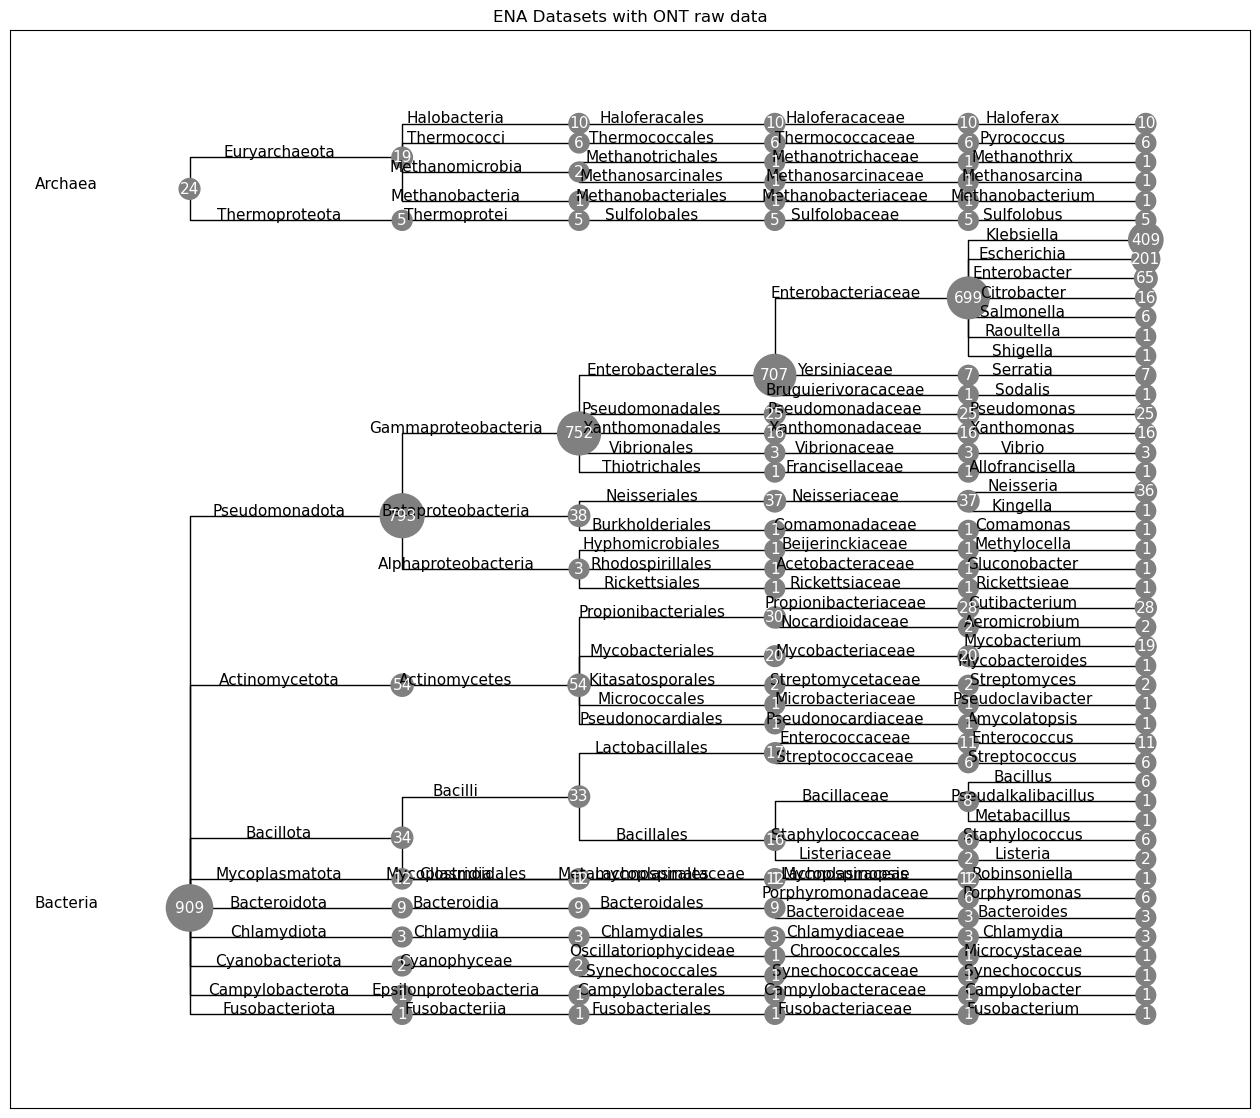

In [17]:
def plot_lineage(df, lvls=6):
    T = nx.DiGraph()
    for lvl in range(0,lvls):
        for val,cnt in df.lineage.str.split(';').str[lvl].value_counts().items():
            if val.strip().replace(" group", ""):
                T.add_node(val.strip().replace(" group", ""), size=cnt)
    for lvl in range(0,lvls-1):
        for edge,cnt in df.lineage.str.split(';').str[lvl:lvl+2].value_counts().items():
            if len(edge) == 2 and None not in edge and " " not in edge:
                u,v = edge
                T.add_edge(u.strip().replace(" group", ""), v.strip().replace(" group", ""))

    pos = graphviz_layout(T, prog="dot", args='-Grankdir="LR"')

    next_nodes = set()
    for v in list(T):
        if not T.out_edges(v):
            for u,v in T.in_edges(v):
                next_nodes.add(u)
    while len(next_nodes) > 0:
        next_nodes_ = set()
        for u in next_nodes:
            new_y = np.median([pos[v][1] for u,v in T.out_edges(u)])
            pos[u] = (pos[u][0], new_y)
            for n,_ in T.in_edges(u):
                next_nodes_.add(n)
        next_nodes = next_nodes_
    for v in ['Archaea','Bacteria']:
        if v in pos:
            pos[v] = (pos[v][0]-90, pos[v][1])
    fig,ax = plt.subplots(figsize=(16, 14))
    nx.draw_networkx(
        T,
        pos,
        with_labels=False,
        node_size=1,
        node_color="white",
        font_size=11,
        font_color="Black",
        ax=ax,
        connectionstyle='angle',
    )
    pos_higher = {}
    for k, v in pos.items():
        pos_higher[k] = (v[0]-140, v[1]+14)
    nx.draw_networkx(
        T,
        pos_higher,
        edgelist=[],
        with_labels=True,
        node_size=0,
        node_color="white",
        font_size=11,
        font_color="Black",
        ax=ax,
        connectionstyle='angle',
    )
    nx.draw_networkx(
        T,
        pos,
        with_labels=True,
        node_size=np.array([int(i) for i in nx.get_node_attributes(T, "size").values()])+200,
        labels=nx.get_node_attributes(T, "size"),
        node_color="Grey",
        edgelist=[],
        font_size=11,
        font_color="White",
        ax=ax,
    )
    ax.set_title("ENA Datasets with ONT raw data")
    plt.show()
plot_lineage(df)

In [18]:
# select non-amplified samples
sel = (df.library_selection.isin(['RANDOM', 'other', 'unspecified', 'size fractionation'])) & \
      (df.library_source == 'GENOMIC') & \
      (df.library_strategy.isin(['WGS', 'OTHER']))

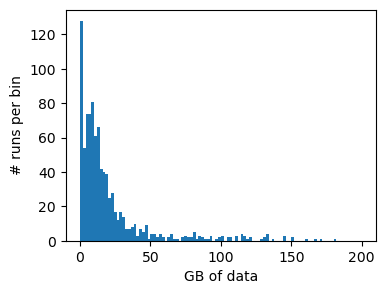

In [19]:
GBs = df.submitted_bytes.astype('float') / 10**9
fig,ax = plt.subplots(figsize=(4,3))
ax.hist(GBs, range=(0,200), bins=100)
ax.set(xlabel="GB of data", ylabel="# runs per bin")
plt.show()

In [20]:
sel &= (GBs > 1) & (GBs < 200)

In [21]:
df.loc[sel].scientific_name.value_counts()

scientific_name
Klebsiella pneumoniae                                          370
Escherichia coli                                                64
Enterobacter cloacae                                            64
Neisseria gonorrhoeae                                           27
Escherichia coli str. K-12 substr. MG1655                       26
Citrobacter freundii                                            14
Klebsiella oxytoca                                              13
Enterococcus faecium                                            11
Escherichia coli K-12                                            9
Cutibacterium acnes                                              8
Mycoplasmopsis bovis                                             7
Serratia marcescens                                              7
Porphyromonas gingivalis W50                                     6
Bacillus anthracis                                               5
Streptococcus suis                            

In [22]:
frequent_sns = df.loc[sel].scientific_name.value_counts().loc[df.loc[sel].scientific_name.value_counts() > 3]
non_frequent_sns = df.loc[sel].scientific_name.value_counts().loc[df.loc[sel].scientific_name.value_counts() <= 3]
frequent_sns.index

Index(['Klebsiella pneumoniae', 'Escherichia coli', 'Enterobacter cloacae',
       'Neisseria gonorrhoeae', 'Escherichia coli str. K-12 substr. MG1655',
       'Citrobacter freundii', 'Klebsiella oxytoca', 'Enterococcus faecium',
       'Escherichia coli K-12', 'Cutibacterium acnes', 'Mycoplasmopsis bovis',
       'Serratia marcescens', 'Porphyromonas gingivalis W50',
       'Bacillus anthracis', 'Streptococcus suis', 'Xanthomonas hydrangeae'],
      dtype='object', name='scientific_name')

In [23]:
# hand-select
pd.set_option('display.max_rows', None)
for sn in frequent_sns.index:
    display(df.loc[sel & (df.scientific_name == sn)].sort_values(['study_title','submitted_bytes'], ascending=False)[[
        'run_accession','study_title', 'project_name', 'sample_title', 'sample_alias', 'sample_description', 
        'lineage', 'isolate', 'submitted_bytes', 'submitted_ftp']])
pd.set_option('display.max_rows', 20)

,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
1664,ERR3654116,a polyclonal multi-species outbreak ofn NDM-1 ...,A polyclonal multi-species outbreak of NDM-1 p...,22-16,22-16,genomic DNA,Bacteria; Pseudomonadota; Gammaproteobacteria;...,22-16,43794829830,ftp.sra.ebi.ac.uk/vol1/run/ERR365/ERR3654116/2...
20240,ERR7850327,Surveillance of carbapenemase-producing Klebsi...,Surveillance of carbapenemase-producing Klebsi...,87569,87569,Klebsiella pneumoniae ST395,Bacteria; Pseudomonadota; Gammaproteobacteria;...,87569,1648599087,ftp.sra.ebi.ac.uk/vol1/run/ERR785/ERR7850327/8...
1589,ERR1474981,Real-time species typing and analysis of antib...,Real-time species typing and analysis of antib...,MinION Sequencing Klebsiella pneumoniae ATCC 1...,11,Klebsiella pneumoniae ATCC 13883,Bacteria; Pseudomonadota; Gammaproteobacteria;...,clinical,10513992145,ftp.sra.ebi.ac.uk/vol1/run/ERR147/ERR1474981/K...
5797,ERR868298,Real-time species typing and analysis of antib...,NaN,Klebsiella pneumoniae ATCC-13883,Klebsiella pneumoniae ATCC-13883,Sequencing Klebsiella pneumoniae ATCC-13883,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,10513992145,ftp.sra.ebi.ac.uk/vol1/run/ERR868/ERR868298/Kp...
10876,ERR2767933,Read sets used in the Deepbinner manuscript,Deepbinner,Deepbinner negative control read set,Deepbinner negative control read set,This is a non-barcoded Oxford Nanopore WGS rea...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,16146853450,ftp.sra.ebi.ac.uk/vol1/run/ERR276/ERR2767933/d...
4720,ERR4699901,Re-sequencing of Klebsiella pneumoniae RH201207,Re-sequencing of Klebsiella pneumoniae RH201207,Re-sequencing of RH201207,RH2012071,Re-sequencing of Klebsiella pneumoniae strain ...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,RH201207,2283813386,ftp.sra.ebi.ac.uk/vol1/run/ERR469/ERR4699901/B...
18153,ERR3485550,Gut microbiome diagnostics in pre-term babies,Nanopore BAMBI (Baby Associated MicroBiota of ...,Nanopore sequencing of Klebsiella pneumoniae i...,Nanopore P8 Klebsiella isolate,Nanopore sequencing of Klebsiella pneumoniae i...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,43331585311,ftp.sra.ebi.ac.uk/vol1/run/ERR348/ERR3485550/0...
2414,ERR5191772,Emerging pan-aminoglycoside resistance among c...,CRE RMT WGS in Spain,AI2764 DNA,AI2764,DNA extracted from AI2764,Bacteria; Pseudomonadota; Gammaproteobacteria;...,147,9096251260,ftp.sra.ebi.ac.uk/vol1/run/ERR519/ERR5191772/A...
2421,ERR5191784,Emerging pan-aminoglycoside resistance among c...,CRE RMT WGS in Spain,AI2934 DNA,AI2934,DNA extracted from AI2934,Bacteria; Pseudomonadota; Gammaproteobacteria;...,395,8925270296,ftp.sra.ebi.ac.uk/vol1/run/ERR519/ERR5191784/A...
19414,ERR5191785,Emerging pan-aminoglycoside resistance among c...,CRE RMT WGS in Spain,AI2993 DNA,AI2993,DNA extracted from AI2993,Bacteria; Pseudomonadota; Gammaproteobacteria;...,147,8735563647,ftp.sra.ebi.ac.uk/vol1/run/ERR519/ERR5191785/A...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
3862,ERR9951991,Methylation based plasmid binning using nanopo...,undefined,ecoli,ecoli,E. coli DH5a with pRW62 plasmid,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,10154039950,ftp.sra.ebi.ac.uk/vol1/run/ERR995/ERR9951991/2...
10871,ERR2603589,Mechanisms of colistin resistance in nosocomia...,Colistin resistance in nosocomial Escherichia ...,Colistin resistant Escherichia coli isolate,E3090,Colistin resistant Escherichia coli isolate ob...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,E3090,47545155827,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2603589/E...
17991,ERR2603588,Mechanisms of colistin resistance in nosocomia...,Colistin resistance in nosocomial Escherichia ...,Colistin resistant Escherichia coli isolate,I1121,Colistin resistant Escherichia coli isolate ob...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,I1121,39817553694,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2603588/A...
4106,ERR2603590,Mechanisms of colistin resistance in nosocomia...,Colistin resistance in nosocomial Escherichia ...,Colistin susceptible Escherichia coli isolate,A783,Colistin susceptible Escherichia coli isolate ...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,A783,19144439954,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2603590/I...
18663,ERR4173917,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,Comparison_E_coli,Comparison_E_coli1,Comparison_E_coli,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,3068446535,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4173917/C...
18676,ERR4179829,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,Comparison_M_bovis_E_coli_All_basecallers,Comparison_M_bovis_E_coli_All_basecallers1,Comparison_M_bovis_E_coli_All_basecallers,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,3068446535,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4179829/C...
2942,ERR10447806,E. coli methylation,Growth Condition Dependent Differences in Meth...,SC469_96,ena-SAMPLE-TAB-27-10-2022-10:17:18:970-138,genomic DNA isolated from E. coli grown for 96...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,SC469,9293041001,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447806/...
836,ERR10447792,E. coli methylation,Growth Condition Dependent Differences in Meth...,SC419_96,ena-SAMPLE-TAB-27-10-2022-10:17:18:970-124,genomic DNA isolated from E. coli grown for 96...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,SC419,8465641024,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447792/...
25480,ERR10447799,E. coli methylation,Growth Condition Dependent Differences in Meth...,SC452_96,ena-SAMPLE-TAB-27-10-2022-10:17:18:970-131,genomic DNA isolated from E. coli grown for 96...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,SC452,7594634578,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447799/...
2937,ERR10447801,E. coli methylation,Growth Condition Dependent Differences in Meth...,SC452_M9_rep1,ena-SAMPLE-TAB-27-10-2022-10:17:18:970-133,genomic DNA isolated from E. coli grown at 37C...,Bacteria; Pseudomonadota; Gammaproteobacteria;...,SC452,7197066436,ftp.sra.ebi.ac.uk/vol1/run/ERR104/ERR10447801/...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
18184,ERR3654117,a polyclonal multi-species outbreak ofn NDM-1 ...,A polyclonal multi-species outbreak of NDM-1 p...,460-16,460-16,genomic DNA,Bacteria; Pseudomonadota; Gammaproteobacteria;...,460-16,15167670065,ftp.sra.ebi.ac.uk/vol1/run/ERR365/ERR3654117/4...
2508,ERR5243236,Emerging pan-aminoglycoside resistance among c...,CRE RMT WGS in Spain,AI2613 DNA,AI2613,DNA extracted from AI2613,Bacteria; Pseudomonadota; Gammaproteobacteria;...,93,39682455176,ftp.sra.ebi.ac.uk/vol1/run/ERR524/ERR5243236/A...
5024,ERR5191792,Emerging pan-aminoglycoside resistance among c...,CRE RMT WGS in Spain,AN2360 DNA,AN2360,DNA extracted from AN2360,Bacteria; Pseudomonadota; Gammaproteobacteria;...,93,11564727405,ftp.sra.ebi.ac.uk/vol1/run/ERR519/ERR5191792/A...
5118,ERR5295516,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2689 DNA,AI2689,DNA extracted from AI2689,Bacteria; Pseudomonadota; Gammaproteobacteria;...,171,9382794420,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295516/A...
2600,ERR5295538,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2762 DNA,AI2762,DNA extracted from AI2762,Bacteria; Pseudomonadota; Gammaproteobacteria;...,125,9017352725,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295538/A...
2649,ERR5353134,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2839 DNA,AI2839,DNA extracted from AI2839,Bacteria; Pseudomonadota; Gammaproteobacteria;...,413,8645651954,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353134/A...
19642,ERR5353155,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2859 DNA,AI2859,DNA extracted from AI2859,Bacteria; Pseudomonadota; Gammaproteobacteria;...,133,8616659456,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353155/A...
2584,ERR5295522,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2697 DNA,AI2697,DNA extracted from AI2697,Bacteria; Pseudomonadota; Gammaproteobacteria;...,171,8547133154,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295522/A...
5224,ERR5353212,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2939 DNA,AI2939,DNA extracted from AI2939,Bacteria; Pseudomonadota; Gammaproteobacteria;...,133,8438482731,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353212/A...
19599,ERR5353095,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2804 DNA,AI2804,DNA extracted from AI2804,Bacteria; Pseudomonadota; Gammaproteobacteria;...,78,7996299374,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353095/A...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
10863,ERR2503988,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,WHO K,WHO K,2016 WHO Neisseria gonorrhoeae reference strain,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,97532042663,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2503988/W...
17978,ERR2504003,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,155_89R,155_89R,"Clinical sample, Bern, Switzerland",Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,92076740873,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2504003/1...
4095,ERR2503999,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,WHO Z,WHO Z,2016 WHO Neisseria gonorrhoeae reference strain,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,85024512846,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2503999/W...
17970,ERR2503993,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,WHO P,WHO P,2016 WHO Neisseria gonorrhoeae reference strain,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,83135463039,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2503993/W...
4097,ERR2504005,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,155_122,155_122,"Clinical sample, Bern, Switzerland",Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,81712238903,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2504005/1...
10869,ERR2504011,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,252_1R,252_1R,"Clinical sample, Bern, Switzerland",Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,81580903498,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2504011/2...
10864,ERR2503989,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,WHO L,WHO L,2016 WHO Neisseria gonorrhoeae reference strain,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,81474283258,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2503989/W...
4092,ERR2503997,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,WHO X,WHO X,2016 WHO Neisseria gonorrhoeae reference strain,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,78601591485,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2503997/W...
4085,ERR2503990,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,WHO M,WHO M,2016 WHO Neisseria gonorrhoeae reference strain,Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,74605425478,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2503990/W...
17984,ERR2504012,Golparian et al. WGS of Neisseria gonorrhoeae ...,ONT MinION sequencer: WGS of Neisseria gonorrh...,252_18R,252_18R,"Clinical sample, Bern, Switzerland",Bacteria; Pseudomonadota; Betaproteobacteria; ...,NaN,73748347890,ftp.sra.ebi.ac.uk/vol1/run/ERR250/ERR2504012/2...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
3767,ERR968974,WTCHG_MARC_Ph1b.2,NaN,Escherichia coli str. K-12 substr. MG1655,E. coli K12 Ph1b.2,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,74788301877,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968974/WT...
3765,ERR968973,WTCHG_MARC_Ph1b.1,NaN,Escherichia coli str. K-12 substr. MG1655,E. coli K12 MG1655 Ph1b.1,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,54199050687,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968973/20...
6059,ERR968964,WTCHG_MARC_Ph1.2,NaN,Escherichia coli str. K-12 substr. MG1655,E. coli K12 extraction2,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,33936029840,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968964/WT...
20799,ERR968963,WTCHG_MARC_Ph1.1,NaN,Escherichia coli str. K-12 substr. MG1655,E. coli K12,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,75708500096,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968963/WT...
1595,ERR1674581,UBC MARC E.coli Oxford Nanopore MinION R9 2D b...,NaN,Escherichia coli str. K-12 substr. MG1655,E.coli K12 MG1655,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,145851863295,ftp.sra.ebi.ac.uk/vol1/run/ERR167/ERR1674581/U...
6068,ERR968971,Phase 1b Evaluation,NaN,Escherichia coli str. K-12 substr. MG1655,E.Coli MARC1b_run1,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,67147945981,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968971/JO...
6070,ERR968972,Phase 1b Evaluation,NaN,Escherichia coli str. K-12 substr. MG1655,E.Coli MARC1b_run2,Escherichia coli str. K-12 substr. MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,44101555461,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968972/JO...
4078,ERR2137852,Nanopore sequencing of E. coli with R9.4 chemi...,lab5 R9.4 bridging experiment,marc_E_coli_K12_MG1655,marc_E_coli_K12_MG1655,E.coli K12 MG1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,121455960786,ftp.sra.ebi.ac.uk/vol1/run/ERR213/ERR2137852/M...
20795,ERR968959,MinION sequencing run for MARC Phase Ia E. coli,MARC Phase Ia E. coli Run # 1,E. coli K12 MG1655,MA_286_R7.3_MARC_K12_03_27_15.tar.gz,MinION sequencing run for MARC Phase Ia E. coli,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,78111527945,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968959/MA...
6056,ERR968960,MinION sequencing run for MARC Phase Ia E. coli,MARC Phase Ia E. coli Run # 1,UCSC_MARC_Phase_Ia_Run_2.tar.gz,UCSC_MARC_Phase_Ia_Run_2.tar.gz,MARC Phase Ia Run 2,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,130272896614,ftp.sra.ebi.ac.uk/vol1/run/ERR968/ERR968960/UC...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
4266,ERR3654115,a polyclonal multi-species outbreak ofn NDM-1 ...,A polyclonal multi-species outbreak of NDM-1 p...,20-16,20-16,genomic DNA,Bacteria; Pseudomonadota; Gammaproteobacteria;...,20-16,22502095606,ftp.sra.ebi.ac.uk/vol1/run/ERR365/ERR3654115/2...
5167,ERR5353121,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2826 DNA,AI2826,DNA extracted from AI2826,Bacteria; Pseudomonadota; Gammaproteobacteria;...,22,6303957432,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353121/A...
5100,ERR5295497,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2668 DNA,AI2668,DNA extracted from AI2668,Bacteria; Pseudomonadota; Gammaproteobacteria;...,18,44023219465,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295497/A...
19503,ERR5295478,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2609 DNA,AI2609,DNA extracted from AI2609,Bacteria; Pseudomonadota; Gammaproteobacteria;...,402,36692133405,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295478/A...
5111,ERR5295509,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2680 DNA,AI2680,DNA extracted from AI2680,Bacteria; Pseudomonadota; Gammaproteobacteria;...,18,35839405608,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295509/A...
5098,ERR5295495,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2666 DNA,AI2666,DNA extracted from AI2666,Bacteria; Pseudomonadota; Gammaproteobacteria;...,18,30503087929,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295495/A...
2522,ERR5295491,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2661 DNA,AI2661,DNA extracted from AI2661,Bacteria; Pseudomonadota; Gammaproteobacteria;...,22,30237647245,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295491/A...
5046,ERR5214333,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2602 DNA,AI2602,DNA extracted from AI2602,Bacteria; Pseudomonadota; Gammaproteobacteria;...,112,29607626071,ftp.sra.ebi.ac.uk/vol1/run/ERR521/ERR5214333/A...
19465,ERR5214358,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2642 DNA,AI2642,DNA extracted from AI2642,Bacteria; Pseudomonadota; Gammaproteobacteria;...,8,24332412187,ftp.sra.ebi.ac.uk/vol1/run/ERR521/ERR5214358/A...
19468,ERR5214359,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2642 DNA,AI2642,DNA extracted from AI2642,Bacteria; Pseudomonadota; Gammaproteobacteria;...,8,22879136233,ftp.sra.ebi.ac.uk/vol1/run/ERR521/ERR5214359/A...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
19829,ERR5420993,Comprehensive genomic survey of carbapenem-res...,CRE global study,AN2363 DNA,AN2363,DNA extracted from AN2363,Bacteria; Pseudomonadota; Gammaproteobacteria;...,328,9438752200,ftp.sra.ebi.ac.uk/vol1/run/ERR542/ERR5420993/A...
5126,ERR5295524,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2699 DNA,AI2699,DNA extracted from AI2699,Bacteria; Pseudomonadota; Gammaproteobacteria;...,325,8680874705,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295524/A...
2835,ERR5420946,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2918 DNA,AI2918,DNA extracted from AI2918,Bacteria; Pseudomonadota; Gammaproteobacteria;...,36,6516326777,ftp.sra.ebi.ac.uk/vol1/run/ERR542/ERR5420946/A...
5222,ERR5353210,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2937 DNA,AI2937,DNA extracted from AI2937,Bacteria; Pseudomonadota; Gammaproteobacteria;...,326,5865927481,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353210/A...
5094,ERR5295481,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2614 DNA,AI2614,DNA extracted from AI2614,Bacteria; Pseudomonadota; Gammaproteobacteria;...,324,51900296690,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295481/A...
19586,ERR5353086,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2623 DNA,AI2623,DNA extracted from AI2623,Bacteria; Pseudomonadota; Gammaproteobacteria;...,145,50390277454,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353086/A...
5256,ERR5353272,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI3012 DNA,AI3012,DNA extracted from AI3012,Bacteria; Pseudomonadota; Gammaproteobacteria;...,2,28184987911,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353272/A...
5229,ERR5353218,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2946 DNA,AI2946,DNA extracted from AI2946,Bacteria; Pseudomonadota; Gammaproteobacteria;...,101,18911901353,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353218/A...
5227,ERR5353216,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2943 DNA,AI2943,DNA extracted from AI2943,Bacteria; Pseudomonadota; Gammaproteobacteria;...,327,17331918958,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353216/A...
5245,ERR5353260,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2991 DNA,AI2991,DNA extracted from AI2991,Bacteria; Pseudomonadota; Gammaproteobacteria;...,36,17160521155,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353260/A...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
19425,ERR5205861,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,BL4_MinION,7,BL4_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,BL4_MinION,7135380684,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205861/B...
19420,ERR5205857,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,V2_MinION,3,V2_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,V2_MinION,5831665299,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205857/V...
2432,ERR5205863,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,BL6_MinION,9,BL6_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,BL6_MinION,5315964269,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205863/B...
2426,ERR5198867,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,B11_MinION,41,B11_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,B11_MinION,4645723970,ftp.sra.ebi.ac.uk/vol1/run/ERR519/ERR5198867/B...
2430,ERR5205856,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,V1_MinION,2,V1_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,V1_MinION,4452729360,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205856/V...
19417,ERR5195736,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,S1_MinION,21,S1_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,S1_MinION,4092007745,ftp.sra.ebi.ac.uk/vol1/run/ERR519/ERR5195736/S...
2428,ERR5205855,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,B2_MinION,12,B2_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,B2_MinION,3625160054,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205855/B...
19422,ERR5205860,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,BL3_MinION,6,BL3_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,BL3_MinION,3545128439,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205860/B...
5028,ERR5205859,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,BL2_MinION,5,BL2_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,BL2_MinION,3305086898,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205859/B...
5026,ERR5205858,Long-read sequencing-based in silico phage typ...,Long-read sequencing and phage typing of Enter...,BL1_MinION,4,BL1_MinION,Bacteria; Bacillota; Bacilli; Lactobacillales;...,BL1_MinION,2701508637,ftp.sra.ebi.ac.uk/vol1/run/ERR520/ERR5205858/B...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
4042,ERR1418238,φ29 Treatment for MinION,NaN,Escherichia coli K-12,E. coli-R4b,Escherichia coli K-12,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,3022315468,ftp.sra.ebi.ac.uk/vol1/run/ERR141/ERR1418238/E...
18524,ERR3890216,EColiK12MG1655 Nanopore R10.3 release,EColiK12MG1655 Nanopore R10.3 release,ecolik12mg1655,ecolik12mg1655_nanopore_R10.3,ecolik12mg1655,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,8651934094,ftp.sra.ebi.ac.uk/vol1/run/ERR389/ERR3890216/e...
1573,ERR1309545,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,92038335199,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309545/e...
4025,ERR1309546,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,80880593359,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309546/e...
1575,ERR1309548,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,63938591538,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309548/e...
17903,ERR1309542,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,56710754457,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309542/e...
4027,ERR1309547,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,144939905913,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309547/e...
4021,ERR1309543,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,116144002652,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309543/e...
4023,ERR1309544,Detecting methylation using the MinION,Nanopore methylation,Escherichia coli str. K-12 substr. ER2925,ecoli_er2925,Escherichia coli str. K-12 substr. ER2925,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,114266917412,ftp.sra.ebi.ac.uk/vol1/run/ERR130/ERR1309544/e...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
4996,ERR5159245,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes nanopore sequencing,KPA171202_H2,C. acnes nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,9175670299,ftp.sra.ebi.ac.uk/vol1/run/ERR515/ERR5159245/K...
3002,ERR5859545,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes Nanopore sequencing,L1_NAT,C. acnes Nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,8656734738,ftp.sra.ebi.ac.uk/vol1/run/ERR585/ERR5859545/L...
19390,ERR5159249,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes nanopore sequencing,09-9,C. acnes nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,8542745148,ftp.sra.ebi.ac.uk/vol1/run/ERR515/ERR5159249/0...
2406,ERR5159246,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes nanopore sequencing,A1,C. acnes nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,7957964645,ftp.sra.ebi.ac.uk/vol1/run/ERR515/ERR5159246/A...
4999,ERR5159248,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes nanopore sequencing,C1,C. acnes nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,7457050259,ftp.sra.ebi.ac.uk/vol1/run/ERR515/ERR5159248/C...
19991,ERR5859539,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes Nanopore sequencing,KPA_KO_NAT,C. acnes Nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,17447582494,ftp.sra.ebi.ac.uk/vol1/run/ERR585/ERR5859539/K...
4990,ERR5159236,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes nanopore sequencing,K2,C. acnes nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,151212576405,ftp.sra.ebi.ac.uk/vol1/run/ERR515/ERR5159236/K...
4998,ERR5159247,Engineering selectivity of Cutibacterium acnes...,Engineering selectivity of Cutibacterium acnes...,C. acnes nanopore sequencing,H1,C. acnes nanopore sequencing,Bacteria; Actinomycetota; Actinomycetes; Propi...,NaN,13320925675,ftp.sra.ebi.ac.uk/vol1/run/ERR515/ERR5159247/H...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
18660,ERR4173916,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,M_bovis_MinION_Guppy,M_bovis_MinION_Guppy11,M_bovis_MinION_Guppy,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,5073120282,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4173916/M...
18668,ERR4179765,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,MinION_Guppy_basecall_All_strains,MinION_Guppy_basecall_All_strains1,MinION_Guppy_basecall_All_strains,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,5072002408,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4179765/M...
4578,ERR4179828,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,MiSeq_All_strains,MiSeq_All_strains1,MiSeq_All_strains,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,15616950376,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4179828/M...
18654,ERR4173913,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,M_bovis_Flongle_Guppy,M_bovis_Flongle_Guppy1,M_bovis_Flongle_Guppy,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,1469482497,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4173913/M...
1950,ERR4179767,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,Flongle_Guppy_basecall_All_strains,Flongle_Guppy_basecall_All_strains1,Flongle_Guppy_basecall_All_strains,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,1468927598,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4179767/M...
18670,ERR4179766,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,MinION_Bonito_basecall_All_strains,MinION_Bonito_basecall_All_strains1,MinION_Bonito_basecall_All_strains,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,1298447318,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4179766/M...
18657,ERR4173915,High quality MinION and Flongle long-read nano...,Taxon-specific basecalling for high quality lo...,M_bovis_MinION_Bonito,M_bovis_MinION_Bonito11,M_bovis_MinION_Bonito,Bacteria; Mycoplasmatota; Mycoplasmoidales; Me...,NaN,1297804693,ftp.sra.ebi.ac.uk/vol1/run/ERR417/ERR4173915/M...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
5183,ERR5353153,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2857 DNA,AI2857,DNA extracted from AI2857,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,9098864603,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353153/A...
5197,ERR5353180,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2884 DNA,AI2884,DNA extracted from AI2884,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,8947311714,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353180/A...
2669,ERR5353167,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2872 DNA,AI2872,DNA extracted from AI2872,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,8424477995,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353167/A...
19511,ERR5295485,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2618 DNA,AI2618,DNA extracted from AI2618,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,29219112821,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295485/A...
19509,ERR5295484,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2617 DNA,AI2617,DNA extracted from AI2617,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,26058802688,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295484/A...
2513,ERR5295483,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2616 DNA,AI2616,DNA extracted from AI2616,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,22352510568,ftp.sra.ebi.ac.uk/vol1/run/ERR529/ERR5295483/A...
19673,ERR5353183,Comprehensive genomic survey of carbapenem-res...,CRE global study,AI2887 DNA,AI2887,DNA extracted from AI2887,Bacteria; Pseudomonadota; Gammaproteobacteria;...,0,12996396377,ftp.sra.ebi.ac.uk/vol1/run/ERR535/ERR5353183/A...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
17324,ERR11027274,Whole-methylome and transcriptome of Porphyrom...,NaN,Excess hemin sample 1,ExH_1,P. gingivalis W50 grown in excess hemin (5 mg/L),Bacteria; Bacteroidota; Bacteroidia; Bacteroid...,NaN,161043220682,ftp.sra.ebi.ac.uk/vol1/run/ERR110/ERR11027274/...
17318,ERR11027272,Whole-methylome and transcriptome of Porphyrom...,NaN,Limited hemin sample 2,LiH_2,P. gingivalis W50 grown in limited hemin (0.2 ...,Bacteria; Bacteroidota; Bacteroidia; Bacteroid...,NaN,136443852222,ftp.sra.ebi.ac.uk/vol1/run/ERR110/ERR11027272/...
1188,ERR11027275,Whole-methylome and transcriptome of Porphyrom...,NaN,Excess hemin sample 2,ExH_2,P. gingivalis W50 grown in excess hemin (5 mg/L),Bacteria; Bacteroidota; Bacteroidia; Bacteroid...,NaN,132616550210,ftp.sra.ebi.ac.uk/vol1/run/ERR110/ERR11027275/...
3651,ERR11027271,Whole-methylome and transcriptome of Porphyrom...,NaN,Limited hemin sample 1,LiH_1,P. gingivalis W50 grown in limited hemin (0.2 ...,Bacteria; Bacteroidota; Bacteroidia; Bacteroid...,NaN,110769675155,ftp.sra.ebi.ac.uk/vol1/run/ERR110/ERR11027271/...
17321,ERR11027273,Whole-methylome and transcriptome of Porphyrom...,NaN,Limited hemin sample 3,LiH_3,P. gingivalis W50 grown in limited hemin (0.2 ...,Bacteria; Bacteroidota; Bacteroidia; Bacteroid...,NaN,104463467154,ftp.sra.ebi.ac.uk/vol1/run/ERR110/ERR11027273/...
17327,ERR11027276,Whole-methylome and transcriptome of Porphyrom...,NaN,Excess hemin sample 3,ExH_3,P. gingivalis W50 grown in excess hemin (5 mg/L),Bacteria; Bacteroidota; Bacteroidia; Bacteroid...,NaN,101721404183,ftp.sra.ebi.ac.uk/vol1/run/ERR110/ERR11027276/...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
3199,ERR7477323,Diagnostic challenges within the Bacillus cere...,Diagnostic challenges within the Bacillus cere...,Bacillus taxonomy study,403206-21,Bacillus taxonomy study,Bacteria; Bacillota; Bacilli; Bacillales; Baci...,403206-21,7948918963,ftp.sra.ebi.ac.uk/vol1/run/ERR747/ERR7477323/4...
3196,ERR7477284,Diagnostic challenges within the Bacillus cere...,Diagnostic challenges within the Bacillus cere...,Bacillus taxonomy study,607738-19,Bacillus taxonomy study,Bacteria; Bacillota; Bacilli; Bacillales; Baci...,607738-19,3906039498,ftp.sra.ebi.ac.uk/vol1/run/ERR747/ERR7477284/4...
3200,ERR7499694,Diagnostic challenges within the Bacillus cere...,Diagnostic challenges within the Bacillus cere...,Bacillus taxonomy study,607632-21,Bacillus taxonomy study,Bacteria; Bacillota; Bacilli; Bacillales; Baci...,607632-21,21912635763,ftp.sra.ebi.ac.uk/vol1/run/ERR749/ERR7499694/6...
5469,ERR7499695,Diagnostic challenges within the Bacillus cere...,Diagnostic challenges within the Bacillus cere...,Bacillus taxonomy study,607095-21,Bacillus taxonomy study,Bacteria; Bacillota; Bacilli; Bacillales; Baci...,607095-21,18435338231,ftp.sra.ebi.ac.uk/vol1/run/ERR749/ERR7499695/6...
3202,ERR7499696,Diagnostic challenges within the Bacillus cere...,Diagnostic challenges within the Bacillus cere...,Bacillus taxonomy study,608121-20,Bacillus taxonomy study,Bacteria; Bacillota; Bacilli; Bacillales; Baci...,608121-20,15067339221,ftp.sra.ebi.ac.uk/vol1/run/ERR749/ERR7499696/6...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
18497,ERR3798589,Five Streptococcus suis complete genomes,MRA_Ssuis_genomes,Streptococcus suis isolated from healthy pig,S10,Streptococcus suis isolated from healthy pig,Bacteria; Bacillota; Bacilli; Lactobacillales;...,S10,2219570691,ftp.sra.ebi.ac.uk/vol1/run/ERR379/ERR3798589/S...
4483,ERR3798592,Five Streptococcus suis complete genomes,MRA_Ssuis_genomes,Streptococcus suis isolated from diseased pig,9401240,Streptococcus suis isolated from diseased pig,Bacteria; Bacillota; Bacilli; Lactobacillales;...,9401240,2074569931,ftp.sra.ebi.ac.uk/vol1/run/ERR379/ERR3798592/9...
18498,ERR3798590,Five Streptococcus suis complete genomes,MRA_Ssuis_genomes,Streptococcus suis isolated from diseased pig,GD-0001,Streptococcus suis isolated from diseased pig,Bacteria; Bacillota; Bacilli; Lactobacillales;...,GD-0001,1673577360,ftp.sra.ebi.ac.uk/vol1/run/ERR379/ERR3798590/G...
18494,ERR3798588,Five Streptococcus suis complete genomes,MRA_Ssuis_genomes,Streptococcus suis isolated from diseased patient,861160,Streptococcus suis isolated from diseased patient,Bacteria; Bacillota; Bacilli; Lactobacillales;...,861160,1499701691,ftp.sra.ebi.ac.uk/vol1/run/ERR379/ERR3798588/8...


,run_accession,study_title,project_name,sample_title,sample_alias,sample_description,lineage,isolate,submitted_bytes,submitted_ftp
18924,ERR4656972,Complete genome sequences of four Xanthomonas ...,Xanthomonas hortorum species level clade strai...,Xanthomonas hydrangeae LMG 31886,LMG 31886,Xanthomonas hydrangeae LMG 31886,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,3537962743,ftp.sra.ebi.ac.uk/vol1/run/ERR465/ERR4656972/L...
18921,ERR4656970,Complete genome sequences of four Xanthomonas ...,Xanthomonas hortorum species level clade strai...,Xanthomonas hydrangeae LMG 31884,LMG 31884,Xanthomonas hydrangeae LMG 31884,Bacteria; Pseudomonadota; Gammaproteobacteria;...,GBBC 2123,2964177983,ftp.sra.ebi.ac.uk/vol1/run/ERR465/ERR4656970/L...
2109,ERR4656973,Complete genome sequences of four Xanthomonas ...,Xanthomonas hortorum species level clade strai...,Xanthomonas hydrangeae LMG 31887,LMG 31887,Xanthomonas hydrangeae LMG 31887,Bacteria; Pseudomonadota; Gammaproteobacteria;...,NaN,2674607897,ftp.sra.ebi.ac.uk/vol1/run/ERR465/ERR4656973/L...
4718,ERR4656971,Complete genome sequences of four Xanthomonas ...,Xanthomonas hortorum species level clade strai...,Xanthomonas hydrangeae LMG 31885,LMG 31885,Xanthomonas hydrangeae LMG 31885,Bacteria; Pseudomonadota; Gammaproteobacteria;...,GBBC 2128,1767501033,ftp.sra.ebi.ac.uk/vol1/run/ERR465/ERR4656971/L...


In [24]:
manual_sel = ['ERR7850327','ERR1474981', 'ERR4699901', 'ERR3485550', 'ERR5191772', 'ERR5353275', 'ERR2868914', 'ERR9793808',
              'ERR9951991', 'ERR2603589', 'ERR4173917', 'ERR10447806', 'ERR5353220', 'ERR1313294', 'ERR9793809', 
              'ERR3654117', 'ERR5243236', 'ERR5295516', 
              'ERR2503988', 'ERR2504003', 'ERR2503999',
              'ERR968973', 'ERR1674581', 'ERR2137852',
              'ERR3654115', 'ERR5353121', 'ERR5295497',
              'ERR5420993', 'ERR5295524', 'ERR5420946',
              'ERR5205861', 'ERR5205857',
              'ERR1309545', 
              'ERR5159245', 'ERR5859545',
              'ERR4173916', 'ERR4179765',
              'ERR5353153', 'ERR5353180',
              'ERR11027274', 'ERR11027272',
              'ERR7477323', 'ERR7477284',
              'ERR3798589', 'ERR3798592', 
              'ERR4656970', 'ERR4656971',
              ]
automatic_sel = df.loc[sel & df.scientific_name.isin(non_frequent_sns.index), 'run_accession'].to_list()

In [25]:
sel = df.run_accession.isin(manual_sel) | df.run_accession.isin(automatic_sel)

In [26]:
#ds_per_scientific_name = 3
#sel_sn = []
#for sn in df.loc[sel].scientific_name.unique():
#    #sel_sn.extend(df.loc[df.scientific_name == sn].index[:ds_per_scientific_name]) # just take first
#    sel_sn.extend(df.loc[df.scientific_name == sn].sort_values('submitted_bytes', ascending=False).index[:ds_per_scientific_name]) # select largest dataset
#sel &= df.index.isin(sel_sn)

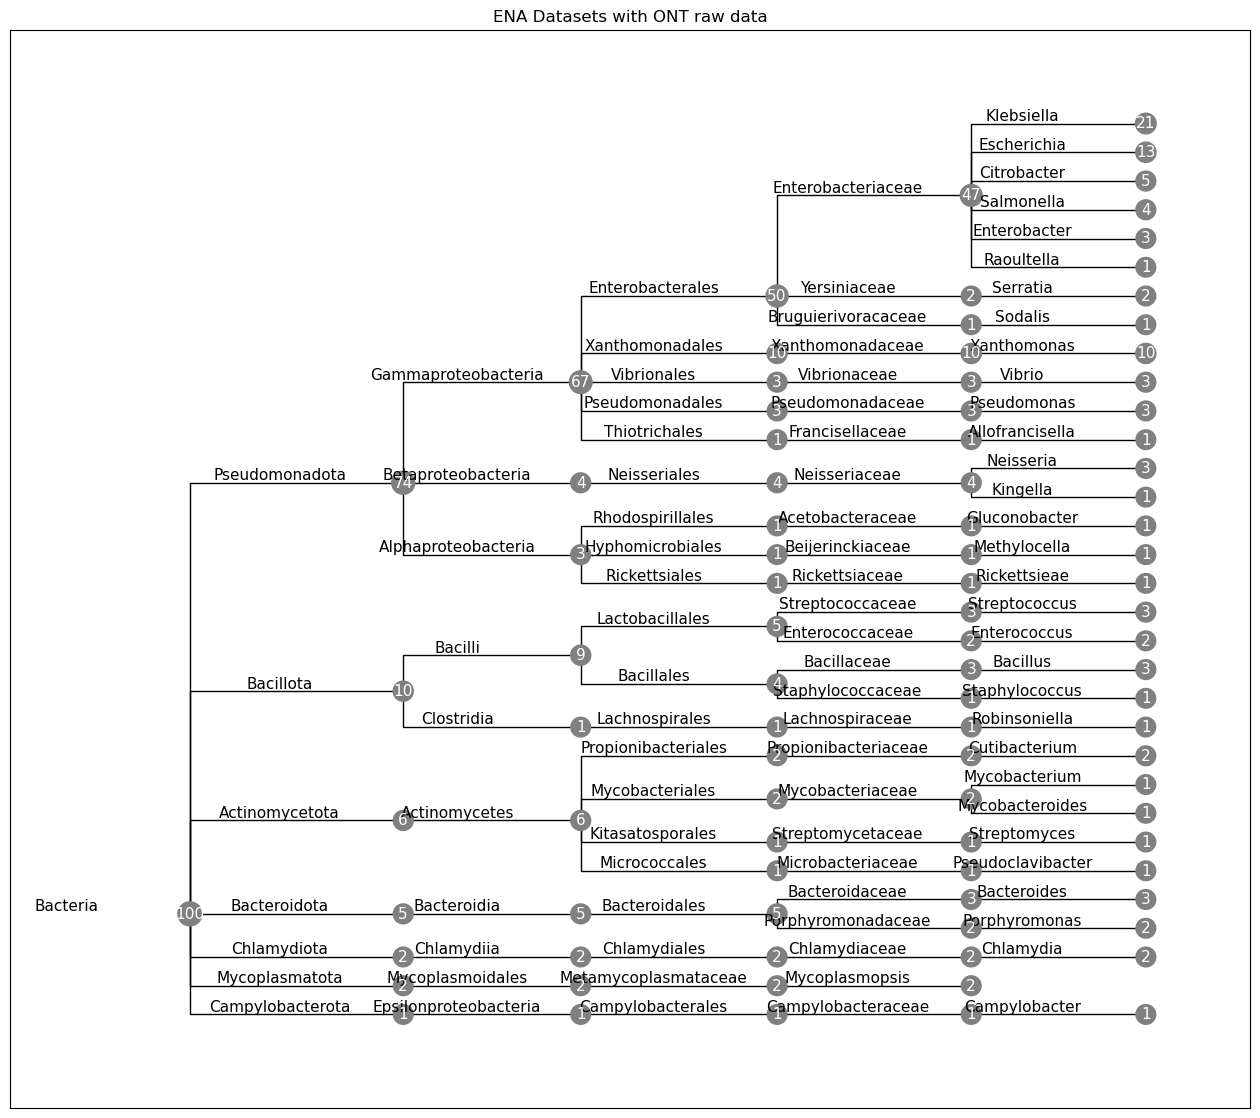

In [27]:
plot_lineage(df.loc[sel], lvls=6)

In [28]:
GBs.loc[sel].sum()

2803.6270919840003

In [29]:
sel.sum(), len(df.loc[sel].scientific_name.unique())

(100, 53)

In [31]:
df.loc[:, 'dataset'] = 'ENA'
df.loc[:, 'sample'] = df['run_accession']
df.loc[:, 'priority'] = 0
df.loc[:, 'NAT_source'] = df['submitted_ftp']
df.loc[:, 'ref_source'] = ''
df.loc[:, 'WGA_source'] = None

In [32]:
df.loc[sel,
    ['dataset', 'sample', 'NAT_source', 'ref_source', 'WGA_source', 'priority', 
     'study_accession', 'experiment_accession', 'sample_accession', 'run_accession', 'submission_accession',
     #'experiment_title', 'instrument_platform', 'base_count', 'experiment_alias', 'protocol_label', 'pcr_isolation_protocol', 'sequencing_method', 
     'study_title', 'project_name', 'sample_title', 'sample_alias', 'sample_description', # 'sample_material', 'run_alias', 
     'tax_id', 'scientific_name', 'lineage', 'isolate', #'taxonomic_identity_marker',  'sub_strain', 'taxonomic_classification',
     'library_construction_protocol', 'library_layout', 'library_name', #'library_selection', 'library_source', 'library_strategy', #'library_gen_protocol',
     'instrument_model',  
     'submitted_bytes', 'submitted_ftp', #'sra_bytes', 'sra_ftp', 'read_count','submitted_format', 
    ]].to_csv("../datasets/ENA_dataset.csv")

In [37]:
! ls "../datasets/"

ENA		 MS061_lactate	No684_Glaeser_Mikroplastik
ENA_dataset.csv  MS061_nitrate	Veillonella.zip
MS061_control	 MicrobeMod	other
